In [5]:
import os

import shutil

from PIL import Image

import torch

import torchvision.transforms as transforms
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

from torchvision.models.segmentation import deeplabv3_resnet50

import torch.nn as nn
import torch.optim as optim

import torchvision

import json

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

import torch.cuda as cuda

import torch.nn.functional as F

from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import precision_recall_fscore_support

from tensorboardX import SummaryWriter

In [50]:
clips = 'D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\train_set\\clips'
new_frames = 'D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\train_set\\tusimple_preprocessed\\training\\frames'

In [51]:
''' create a new name for each frame: here the directories' names
e.g. 'clips/0531\\1492629775931278791\\20.jpg' becomes  '0531_1492629775931278791.jpg' '''

for i in os.listdir(clips):
    # print(os.listdir(os.path.join(clips, i)))
    for j in os.listdir(os.path.join(clips, i)):
        # print('y = ',j)
        for k in os.listdir(os.path.join(clips,i,j)):
            # get the 20th frame
            frame = os.path.join(clips, i, j, k)
            # print(frame)
            if frame.endswith('20.jpg'):
                tmp = frame[:-7].split('\\')[-2:]
                # print(tmp)
                new_fn = f'{tmp[0]}_{tmp[1]}.jpg'
                new_file = os.path.join(new_frames, new_fn)
                if os.path.exists(new_file):
                    print('File already exists. Skipping.')
                else:
                    new_file = os.path.normpath(new_file)
                    print('New File:', new_file)
                    shutil.copy(frame, new_file)

File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File already exists. Skipping.
File alr

In [52]:
'''
Generates and writes the corresponding lane masks for the given images
'''
# create a mask of all zeros

def generate_lane_mask(row, training_set):
    
    mask = np.zeros((720, 1280, 3))
    h_samples = row.h_samples
    lanes = row.lanes
    raw_file = row.raw_file

    # create mask: lane: 1, non-lane: 0
    for lane in lanes:    
        '''
        -2 indicates no line in the specified point, so we omit the points from lane markings list
        ''' 
        h_samples_updated = [y for x, y in zip(lane, h_samples) if x != -2]
        lane = [x for x in lane if x != -2]
        lane_points = np.array(list(zip(lane, h_samples_updated)))
        # add lane markings to the mask we created
        cv2.polylines(mask, [lane_points], False, (255, 255, 255), thickness=15)
        
        # write the lane mask to the desired directory
        if training_set:   
            path = 'D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\train_set\\tusimple_preprocessed\\training\\lane-masks'
        else:
            path = 'D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\test_set\\tusimple_preprocessed_test\\lane-masks'
        '''
            name each mask according to its image's name. 
            e.g. 'clips\\0531\\1492629775931278791\\20.jpg' becomes '0531_1492629775931278791.jpg'
        '''
        tmp = raw_file[:-7].split('/')[-2:]
        mask_fname = f'{tmp[0]}_{tmp[1]}.jpg'
        new_file = os.path.join(path, mask_fname)
        cv2.imwrite(new_file, mask)
        
    return mask_fname

In [13]:
def load_json_file(file_path):
    """Loads a JSON file and returns a Pandas DataFrame."""
    with open(file_path, 'r') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    return df

In [54]:
df_0601 = load_json_file('D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\train_set\\label_data_0601.json')
df_0313 = load_json_file('D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\train_set\\label_data_0313.json')
df_0531 = load_json_file('D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\train_set\\label_data_0531.json')

df = pd.concat([df_0601, df_0313, df_0531])

print(df)

                                                 lanes  \
0    [[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, ...   
1    [[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, 558,...   
2    [[-2, -2, -2, -2, -2, 629, 620, 611, 602, 590,...   
3    [[-2, -2, -2, -2, -2, -2, -2, -2, 552, 530, 50...   
4    [[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, ...   
..                                                 ...   
353  [[-2, -2, -2, -2, -2, -2, -2, -2, -2, 584, 549...   
354  [[-2, -2, -2, -2, -2, -2, -2, -2, -2, 604, 559...   
355  [[-2, -2, -2, -2, -2, -2, -2, 613, 601, 587, 5...   
356  [[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, ...   
357  [[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, 560,...   

                                             h_samples  \
0    [160, 170, 180, 190, 200, 210, 220, 230, 240, ...   
1    [160, 170, 180, 190, 200, 210, 220, 230, 240, ...   
2    [160, 170, 180, 190, 200, 210, 220, 230, 240, ...   
3    [160, 170, 180, 190, 200, 210, 220, 230, 240, ...   
4    [160, 17

In [55]:
class LaneDataset(Dataset):
    def __init__(self, images_path, masks_path, transform=None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.transform = transform
        self.image_list = os.listdir(images_path)
        self.mask_list = os.listdir(masks_path)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_name = self.image_list[idx]
        mask_name = self.mask_list[idx]
        image = Image.open(os.path.join(self.images_path, image_name))
        mask = Image.open(os.path.join(self.masks_path, mask_name)).convert('L')

        if self.transform:
            image = self.transform(image)

        mask_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
        
        mask = mask_transform(mask)

        return image, mask

### DeepLabV3+ Model Architecture

In [10]:
class DeepLabModel(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabModel, self).__init__()
        
        # Load the pre-trained DeepLabV3 model with ResNet-50 backbone
        self.model = deeplabv3_resnet50(weights=True, progress=True)
        
        # Modify the classifier's last layer for the desired number of classes
        self.model.classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

    def forward(self, x):
        # Forward pass through the DeepLabV3 model
        return self.model(x)

In [11]:
# Define the Dice Loss
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, input, target):
        smooth = 1.0  # Smoothing factor to prevent division by zero
        input_flat = input.view(-1)
        target_flat = target.view(-1)

        intersection = torch.sum(input_flat * target_flat)
        union = torch.sum(input_flat) + torch.sum(target_flat)

        dice_coefficient = (2.0 * intersection + smooth) / (union + smooth)
        dice_loss = 1.0 - dice_coefficient  # Convert to Dice Loss (minimize)

        return dice_loss

In [12]:
# Hyperparameters
num_classes = 1  # For lane or non-lane prediction

In [59]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [60]:
train_data_dir = 'D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\train_set\\tusimple_preprocessed\\training'
images_path = os.path.join(train_data_dir, 'frames')
masks_path = os.path.join(train_data_dir, 'lane-masks')

train_dataset = LaneDataset(images_path, masks_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [61]:
# CUDA_LAUNCH_BLOCKING=1

In [66]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

model = DeepLabModel(num_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
# Define the Dice Loss criterion
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

cuda


d:\Pranshu\MS_Colleges\SRH_Hiedelberg\Semester_4\Master_Thesis\Topic\Prof_Swati_Topics\Lane_Detection\TF_LD_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Calculate Intersection Over Union

In [67]:
def calculate_iou(pred, target):
    pred = (pred > 0.5).float()  # Convert to binary mask (assuming you used sigmoid activation)
    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)  # Add a small epsilon to avoid division by zero
    return iou

In [68]:
def train_model(model, dataloader, criterion, optimizer, device, num_epochs, log_dir='./logs'):
    model.train()
    writer = SummaryWriter(log_dir)
    step = 0

    loss_values = []   # List to store loss values per step/epoch
    iou_values = []    # List to store IoU values per step/epoch
    f1_values = []     # List to store F1 scores per step/epoch
    recall_values = [] # List to store recall scores per step/epoch
    precision_values = []  # List to store precision scores per step/epoch

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_iou = 0.0  # Track IoU
        running_f1 = 0.0
        running_recall = 0.0
        running_precision = 0.0

        for i, (inputs, masks) in enumerate(dataloader):
            inputs, masks = inputs.to(device), masks.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs_dict = model(inputs)
                outputs = outputs_dict['out']
                outputs = torch.nn.functional.interpolate(outputs, size=(224, 224), mode="bilinear", align_corners=False)

                # Apply sigmoid activation to ensure outputs are in [0, 1] range
                outputs_sigmoid = torch.sigmoid(outputs)
                loss = criterion(outputs_sigmoid, masks)
                loss.backward()
                optimizer.step()

                # Calculate IoU
                preds = torch.sigmoid(outputs) > 0.5
                iou = calculate_iou(preds, masks)
                running_iou += iou.item()

                # Convert predictions and masks to binary format
                preds_binary = preds.float()  # Convert to 0 or 1
                masks_binary = masks.float()  # Convert to 0 or 1

                # Calculate F1 score, recall, and precision for this batch
                batch_f1, batch_recall, batch_precision, _ = precision_recall_fscore_support(
                    masks_binary.cpu().numpy().flatten().astype(int),
                    preds_binary.cpu().numpy().flatten().astype(int),
                    average="binary",
                    zero_division=1  # Set to 1 to avoid "UndefinedMetricWarning"
                )
                
                running_f1 += batch_f1
                running_recall += batch_recall
                running_precision += batch_precision

                running_loss += loss.item()

                if i % 10 == 9:  # Print every 10 mini-batches
                    print(f"Epoch {epoch+1}/{num_epochs}, Step {i+1}/{len(dataloader)}, Loss: {running_loss/10:.4f}, IoU: {running_iou/10:.4f}")
                    writer.add_scalar('Loss/train', running_loss/10, step)
                    writer.add_scalar('IoU/train', running_iou/10, step)

                    running_loss = 0.0
                    running_iou = 0.0

                step += 1

        # Calculate the average F1 score, recall, and precision for the entire epoch
        avg_f1 = running_f1 / len(dataloader)
        avg_recall = running_recall / len(dataloader)
        avg_precision = running_precision / len(dataloader)

        # Store loss, IoU, F1, recall, and precision values
        loss_values.append(running_loss / len(dataloader))
        iou_values.append(running_iou / len(dataloader))
        f1_values.append(avg_f1)
        recall_values.append(avg_recall)
        precision_values.append(avg_precision)

        writer.add_scalar('F1/train', avg_f1, epoch)
        writer.add_scalar('Recall/train', avg_recall, epoch)
        writer.add_scalar('Precision/train', avg_precision, epoch)

        # Check if this is the final epoch and print the IoU
        if epoch == num_epochs - 1:
            final_iou = running_iou / len(dataloader)
            print(f"Final Epoch {epoch+1}/{num_epochs}, IoU: {final_iou:.4f}")

    writer.close()
    print('Training complete!')

    # Calculate the overall F1 score, recall, and precision
    overall_f1 = sum(f1_values) / len(f1_values)
    overall_recall = sum(recall_values) / len(recall_values)
    overall_precision = sum(precision_values) / len(precision_values)

    print("Overall F1 Score:", overall_f1)
    print("Overall Recall:", overall_recall)
    print("Overall Precision:", overall_precision)

    # Return loss_values, iou_values, f1_values, recall_values, and precision_values
    return loss_values, iou_values, overall_f1, overall_recall, overall_precision, final_iou

In [69]:
# Start training
loss_values, iou_values, final_f1_values, final_recall_values, final_precision_values, final_iou = train_model(model, train_loader, criterion, optimizer, device, num_epochs=10, log_dir='./logs')

Epoch 1/10, Step 10/454, Loss: 0.8552, IoU: 0.0949
Epoch 1/10, Step 20/454, Loss: 0.7853, IoU: 0.1539
Epoch 1/10, Step 30/454, Loss: 0.7351, IoU: 0.1940
Epoch 1/10, Step 40/454, Loss: 0.6681, IoU: 0.2616
Epoch 1/10, Step 50/454, Loss: 0.6084, IoU: 0.3237
Epoch 1/10, Step 60/454, Loss: 0.5509, IoU: 0.3579
Epoch 1/10, Step 70/454, Loss: 0.5015, IoU: 0.3861
Epoch 1/10, Step 80/454, Loss: 0.4736, IoU: 0.4053
Epoch 1/10, Step 90/454, Loss: 0.4437, IoU: 0.4297
Epoch 1/10, Step 100/454, Loss: 0.4292, IoU: 0.4384
Epoch 1/10, Step 110/454, Loss: 0.4140, IoU: 0.4500
Epoch 1/10, Step 120/454, Loss: 0.4081, IoU: 0.4522
Epoch 1/10, Step 130/454, Loss: 0.3943, IoU: 0.4651
Epoch 1/10, Step 140/454, Loss: 0.3958, IoU: 0.4611
Epoch 1/10, Step 150/454, Loss: 0.3934, IoU: 0.4641
Epoch 1/10, Step 160/454, Loss: 0.3860, IoU: 0.4679
Epoch 1/10, Step 170/454, Loss: 0.3810, IoU: 0.4732
Epoch 1/10, Step 180/454, Loss: 0.3830, IoU: 0.4683
Epoch 1/10, Step 190/454, Loss: 0.3734, IoU: 0.4776
Epoch 1/10, Step 200/

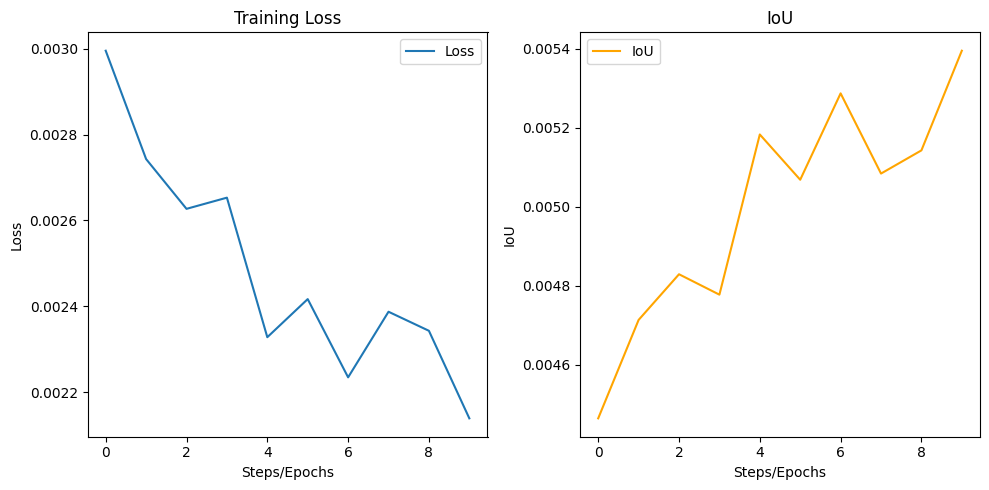

In [70]:
# Assuming you have stored loss and IoU values during training

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Loss')
plt.xlabel('Steps/Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(iou_values, label='IoU', color='orange')
plt.xlabel('Steps/Epochs')
plt.ylabel('IoU')
plt.title('IoU')
plt.legend()

plt.tight_layout()
plt.show()

### Save Model

In [71]:
torch.save(model.state_dict(), 'D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\models\\DeepLabV3_model.pth')

### Test Data 

In [6]:
# Replace the directory path with the one you want to create
base_directory = 'D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\test_set'

# Create main folder 'tusimple_preprocessed'
main_folder = os.path.join(base_directory, 'tusimple_preprocessed_test')
os.makedirs(main_folder, exist_ok=True)

# Create 'frames' and 'lane-masks' folders inside 'training'
frames_folder = os.path.join(main_folder, 'frames')
lane_masks_folder = os.path.join(main_folder, 'lane-masks')
os.makedirs(frames_folder, exist_ok=True)
os.makedirs(lane_masks_folder, exist_ok=True)

In [7]:
test_clips = 'D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\test_set\\clips'
new_test_frames = 'D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\test_set\\tusimple_preprocessed_test\\frames'

### Preprocessed Test Data Directory 

In [8]:
''' create a new name for each frame: here the directories' names
e.g. 'clips/0531/1492629775931278791/20.jpg' becomes  '0531_1492629775931278791.jpg' '''

for i in os.listdir(test_clips):
    for j in os.listdir(os.path.join(test_clips, i)):
        for k in os.listdir(os.path.join(test_clips, i, j)):
            # get the 20th frame
            frame = os.path.join(test_clips, i, j, k)
            frame = os.path.normpath(frame)  # Normalize the path
            if frame.endswith('20.jpg'):
                tmp = frame[:-7].split(os.path.sep)[-2:]
                new_fn = f'{tmp[0]}_{tmp[1]}.jpg'
                new_file = os.path.join(new_test_frames, new_fn)
                new_file = os.path.normpath(new_file)  # Normalize the path
                shutil.copy(frame, new_file)

### Load JSON File

In [14]:
df_test_json = load_json_file('D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\test_label.json')

In [15]:
# Define the LaneDataset class for test data
class TestLaneDataset(Dataset):
    def __init__(self, images_path, transform):
        self.images_path = images_path
        self.transform = transform
        self.image_list = os.listdir(images_path)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_name = self.image_list[idx]
        image = Image.open(os.path.join(self.images_path, image_name))

        if self.transform:
            image = self.transform(image)

        return image, image_name

In [16]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet-50 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_data_dir = 'D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\test_set\\tusimple_preprocessed_test'
images_path = os.path.join(test_data_dir, 'frames')
masks_path = os.path.join(test_data_dir, 'lane-masks')

test_dataset = TestLaneDataset(images_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### Load the saved model

In [17]:
model_path = 'D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\models\\DeepLabV3_model.pth'
loaded_model = DeepLabModel(num_classes)

# GPU
# loaded_model.load_state_dict(torch.load(model_path))

# CPU 
loaded_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
loaded_model.eval()

# Move the model to the same device as the input data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
device = torch.device('cpu')
loaded_model.to(device)

d:\Pranshu\MS_Colleges\SRH_Hiedelberg\Semester_4\Master_Thesis\Topic\Prof_Swati_Topics\Lane_Detection\TF_LD_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda


DeepLabModel(
  (model): DeepLabV3(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

In [18]:
def predict_and_visualize(model, dataloader, num_images=10):
    model.eval()
    with torch.no_grad():
        for idx, (inputs, image_names) in enumerate(dataloader):
            if idx >= num_images:
                break  # Stop after displaying top num_images images

            inputs = inputs.to(device)  # Move input data to the same device as the model
            outputs_dict = model(inputs)
            outputs = outputs_dict['out']
            preds = torch.sigmoid(outputs) > 0.5
            pred_mask = preds.squeeze().cpu().numpy().astype(np.uint8)  # Convert to uint8

            # Load the original image
            original_image_path = os.path.join(images_path, image_names[0])
            original_image = cv2.imread(original_image_path)
            original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

            # Resize the predicted mask to match the dimensions of the original image
            pred_mask_resized = cv2.resize(pred_mask, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

            # Create a black background and overlay the white lane mask
            black_background = np.zeros_like(original_image)
            black_background[pred_mask_resized == 1] = [255, 255, 255]  # Set detected lane to white

            # Blend the images to visualize the lanes
            blended_image = cv2.addWeighted(original_image, 0.7, black_background, 0.3, 0)

            # Combine the original image and predicted image side by side
            combined_image = np.concatenate((original_image, blended_image), axis=1)

            # Visualize the original image and predicted image side by side
            plt.figure(figsize=(15, 6))
            plt.imshow(combined_image)
            plt.axis('off')
            plt.title(f'Top 10 Test Images: {idx + 1}')
            plt.show()

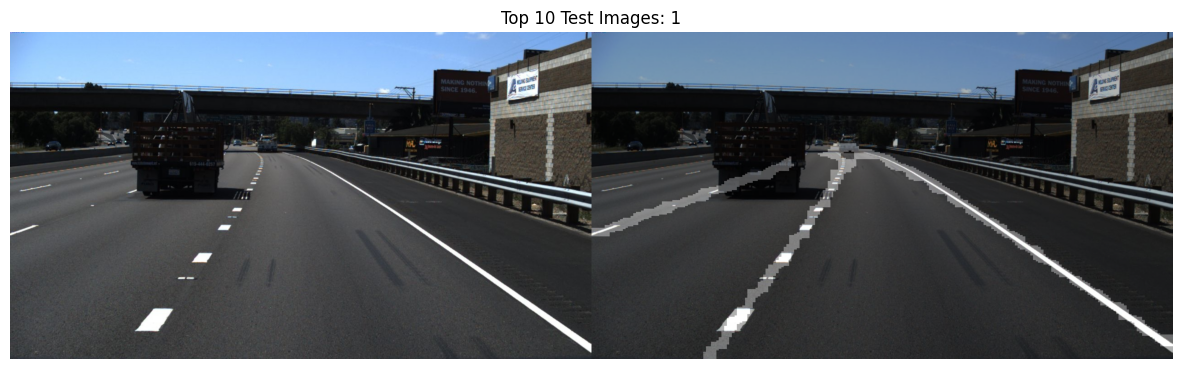

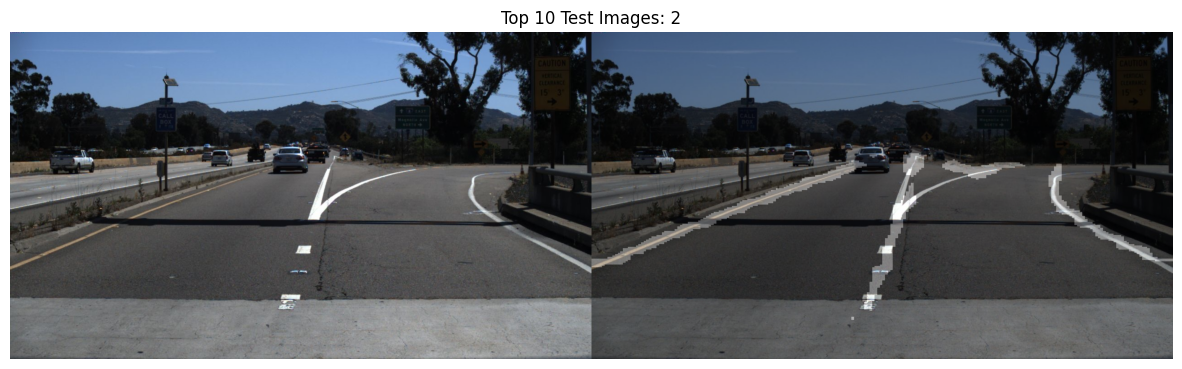

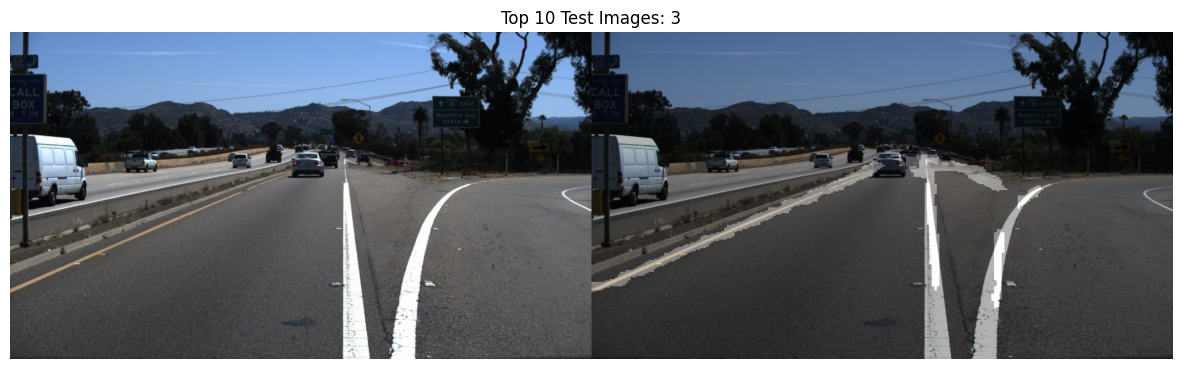

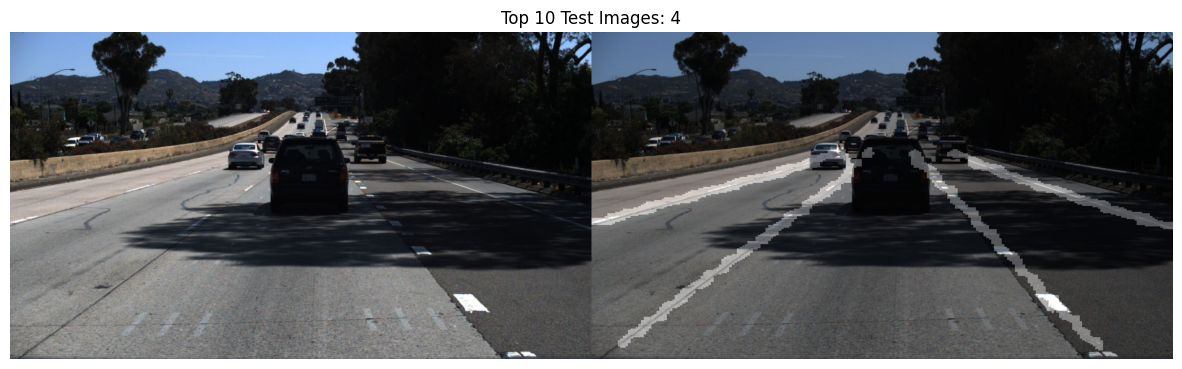

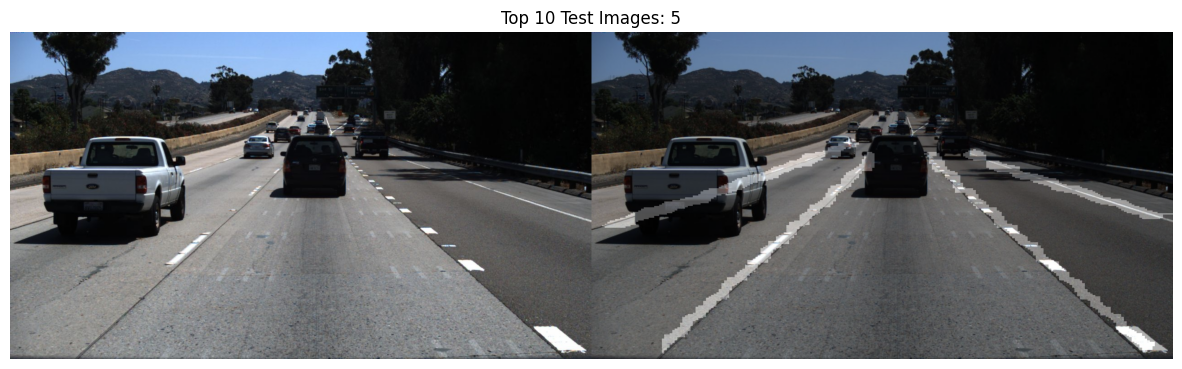

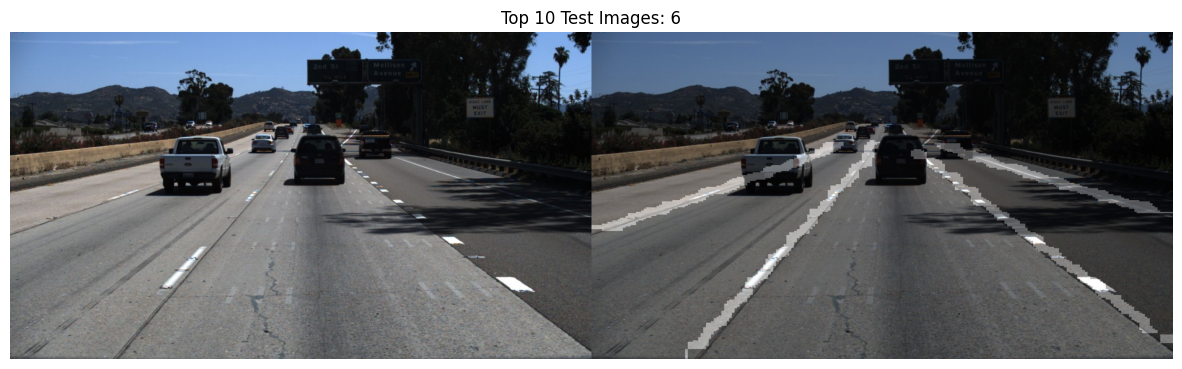

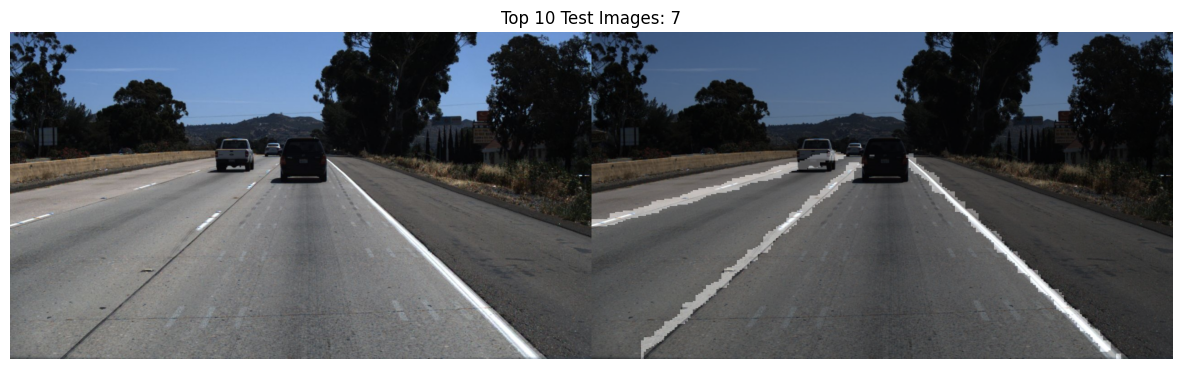

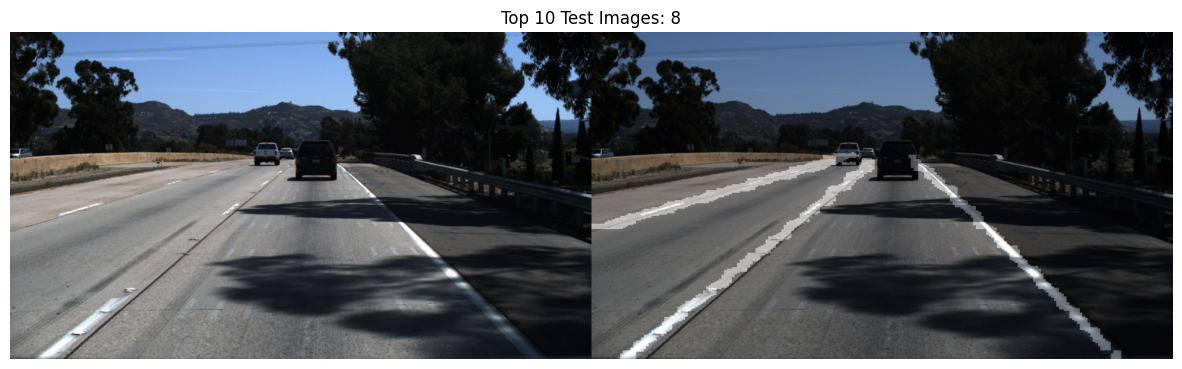

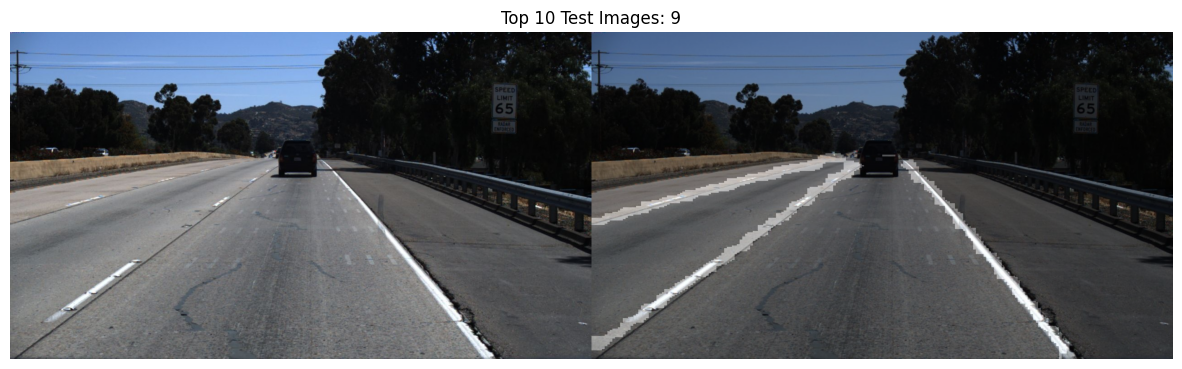

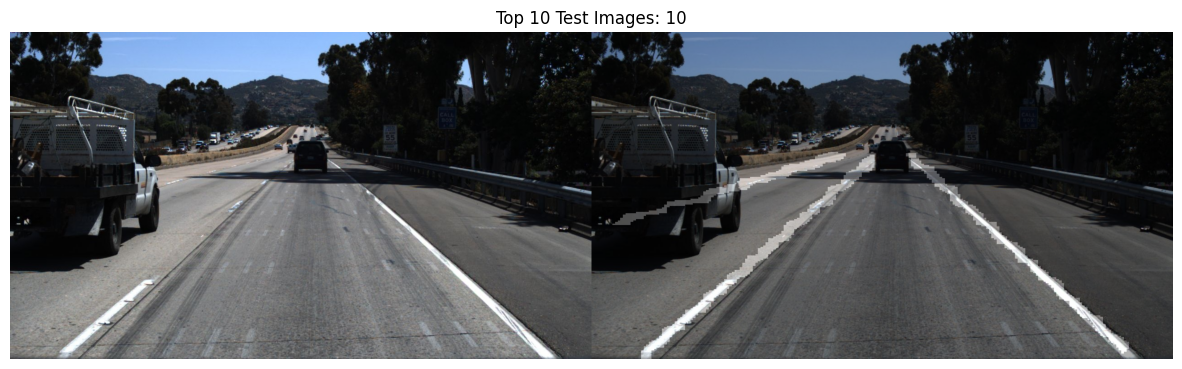

In [19]:
# Predict and visualize top 10 test images and predictions
predict_and_visualize(loaded_model, test_loader, num_images=10)

GRAD-CAM Method

In [20]:
import cv2
import numpy as np
import torch.nn.functional as F

In [32]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        # Hook the target layer to get gradients
        self.hooks = self.target_layer.register_forward_hook(self.save_gradient)

    def save_gradient(self, module, input, output):
        # This is a hook function to get gradients of the activations
        print("Output Type:", type(output))
        print("Output Shape:", output.shape)
        self.gradients = output[0].grad

    def __call__(self, inputs):
        """
        Calculate Grad-CAM saliency map.
        """
        # Forward pass
        self.model.eval()
        outputs = self.model(inputs)

        # Zero grads
        self.model.zero_grad()

        # Backward pass with specified class
        outputs.backward(gradient=outputs.data, retain_graph=True)

        # Get activations and gradients from the target layer
        activations = self.target_layer(inputs).detach()

        # Global Average Pooling (GAP) to get the weights
        weights = F.adaptive_avg_pool2d(self.gradients, 1)

        # Compute the weighted combination of forward activation maps
        saliency_map = torch.mul(activations, weights).sum(dim=1, keepdim=True)
        saliency_map = F.relu(saliency_map)  # We only take the positive gradients
        saliency_map = F.interpolate(saliency_map, size=(224, 224),
                                     mode='bilinear', align_corners=False)

        saliency_map = saliency_map.squeeze().cpu().numpy()
        saliency_map = cv2.normalize(saliency_map, None, 0, 255, cv2.NORM_MINMAX)

        return saliency_map

In [33]:
def overlay_heatmap(heatmap, original_img, alpha=0.5, display=False):
    # Overlay the heatmap on original image
    heatmap = cv2.applyColorMap(np.uint8(heatmap), cv2.COLORMAP_JET)
    final_img = cv2.addWeighted(heatmap, alpha, original_img, 1 - alpha, 0)
    if display:
        plt.imshow(final_img)
        plt.axis('off')
        plt.show()
    return final_img

In [34]:
# Set the target layer for Grad-CAM (usually the last convolutional layer)
# target_layer = next(reversed(loaded_model.children()))
target_layer = list(loaded_model.children())[-1]

In [35]:
# Initialize GradCAM
grad_cam = GradCAM(loaded_model, target_layer)

In [36]:
# Apply GradCAM on some images
for idx, (inputs, image_names) in enumerate(test_loader):
    if idx >= 10:
        break
    inputs = inputs.to(device)
    original_image = cv2.imread(os.path.join(images_path, image_names[0]))
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    heatmap = grad_cam(inputs)
    overlayed_img = overlay_heatmap(heatmap, original_image, alpha=0.5, display=True)

KeyError: 0

### Segmentation function With LIME

In [48]:
def segment_quickshift(image, kernel_size=4, max_dist=200, ratio=0.2):
    """
    Segmentation function using quickshift from skimage.segmentation.
    """
    
    # Apply quickshift segmentation
    segments = quickshift(image, kernel_size=kernel_size, max_dist=max_dist, ratio=ratio)
    
    return segments

In [52]:
def model_predict_single(image, model):
    model.eval()  # Ensure the model is in evaluation mode

    # Handle the case when multiple perturbed images are passed together
    if len(image.shape) == 4:
        img_tensor = torch.tensor(image).float().permute(0, 3, 1, 2).to(device)
    else:
        img_tensor = torch.tensor(image).float().permute(2, 0, 1).unsqueeze(0).to(device)

    # Get the model predictions
    with torch.no_grad():
        outputs_dict = model(img_tensor)
        outputs = outputs_dict['out']

    # Apply sigmoid and get the predictions as numpy array
    preds = torch.sigmoid(outputs).cpu().numpy()

    # If you're expecting a single label for each image, you might need to further process 'preds' to get the desired output
    # For instance, if your model's output is a segmentation map, you could take the argmax across the channel dimension
    # preds = np.argmax(preds, axis=1)
    
    return preds


In [53]:
def explain_with_lime(model, image, segmentation_fn=segment_quickshift):
    """
    Get LIME explanation for a given image using the provided segmentation function.
    """
    explainer = lime_image.LimeImageExplainer()
    
    explanation = explainer.explain_instance(
        image,
        lambda img: model_predict_single(img, model),  # using the modified single image prediction function
        segmentation_fn=segmentation_fn,
        top_labels=1, 
        hide_color=0, 
        num_samples=100  # Increase this for more accuracy, but it will be slower
    )
    
    return explanation

In [54]:
# Example usage:

image_path = "D:\\Pranshu\\MS_Colleges\\SRH_Hiedelberg\\Semester_4\\Master_Thesis\\Topic\\Prof_Swati_Topics\\Lane_Detection\\TF_LD_env\\TuSimple_Dataset\\TUSimple\\test_set\\tusimple_preprocessed_test\\frames\\0530_1492626047222176976_0.jpg" # replace this with your path
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

explanation = explain_with_lime(loaded_model, image)

100%|██████████| 100/100 [04:32<00:00,  2.72s/it]


MemoryError: Unable to allocate 309. TiB for an array with shape (720, 1280, 100, 720, 1280) and data type float32